# Jupyter Notbook for phoneme coverage analysis

This jupyter notebook checks dataset configured in config.json for phoneme coverage.
As mentioned here https://github.com/mozilla/TTS/wiki/Dataset#what-makes-a-good-dataset a good phoneme coverage is recommended.

Most parameters will be taken from config.json file in mozilla tts repo so please ensure it's configured correctly for your dataset.
This notebook used lots of existring code from the TTS repo to ensure future compatibility.

Many thanks to Neil Stoker supporting me on this topic :-).

I provide this notebook without any warrenty but it's hopefully useful for your dataset analysis.

Happy TTS'ing :-)

Thorsten Müller

* https://github.com/thorstenMueller/deep-learning-german-tts
* https://discourse.mozilla.org/t/contributing-my-german-voice-for-tts/

In [1]:
# set some vars
# TTS_PATH = "/home/thorsten/___dev/tts/mozilla/TTS"
CONFIG_FILE = "/path/to/config/config.json"
CHARS_TO_REMOVE = ".,:!?'"

In [2]:
# import stuff
from TTS.utils.io import load_config
from TTS.datasets.preprocess import load_meta_data
from TTS.utils.text import phoneme_to_sequence, sequence_to_phoneme
from tqdm import tqdm
from matplotlib import pylab as plt
from multiprocessing import Pool, cpu_count

# extra imports that might not be included in requirements.txt
import collections
import operator



In [3]:
# Load config.json properties
CONFIG = load_config(CONFIG_FILE)

# Load some properties from config.json
CONFIG_METADATA = sorted(load_meta_data(CONFIG.datasets)[0])
CONFIG_METADATA = CONFIG_METADATA
CONFIG_DATASET = CONFIG.datasets[0]
CONFIG_PHONEME_LANGUAGE = CONFIG.phoneme_language
CONFIG_TEXT_CLEANER = CONFIG.text_cleaner
CONFIG_ENABLE_EOS_BOS_CHARS = CONFIG.enable_eos_bos_chars

# Will be printed on generated output graph
CONFIG_RUN_NAME = CONFIG.run_name
CONFIG_RUN_DESC = CONFIG.run_description

| Trainset (#): 34277
 | Evalset (#): 684


In [4]:
# print some debug information on loaded config values
print(" > Run name: " + CONFIG_RUN_NAME + " (" + CONFIG_RUN_DESC + ")")
print(" > Dataset files: " + str(len(CONFIG_METADATA)))
print(" > Phoneme language: " + CONFIG_PHONEME_LANGUAGE)
print(" > Used text cleaner: " + CONFIG_TEXT_CLEANER)
print(" > Enable eos bos chars: " + str(CONFIG_ENABLE_EOS_BOS_CHARS))

> Run name: gothic_tts (tacotron2 with ddc and batch-normalization, multispeaker(31 speakers) with gst)
 > Dataset files: 1000
 > Phoneme language: de
 > Used text cleaner: basic_german_cleaners
 > Enable eos bos chars: False


In [5]:
def get_phoneme_from_sequence(text):
    temp_list = []
    if len(text[0]) > 0:
        temp_text = text[0].rstrip('\n')
        for rm_bad_chars in CHARS_TO_REMOVE:
            temp_text = temp_text.replace(rm_bad_chars,"")
        seq = phoneme_to_sequence(temp_text, [CONFIG_TEXT_CLEANER], CONFIG_PHONEME_LANGUAGE, CONFIG_ENABLE_EOS_BOS_CHARS)
        text = sequence_to_phoneme(seq)
        text = text.replace(" ","")
        temp_list.append(text)
    return temp_list

In [6]:
# Get phonemes from metadata
phonemes = []

with Pool(cpu_count()-1) as p:
    
    phonemes = list(tqdm(p.imap(get_phoneme_from_sequence, CONFIG_METADATA), total=len(CONFIG_METADATA)))
    phonemes = [i for sub in phonemes for i in sub]

31%|███       | 306/1000 [00:02<00:05, 124.09it/s][WARNING] fount 1 utterances containing language switches on lines 1
[WARNING] extra phones may appear in the "de" phoneset
[WARNING] language switch flags have been kept (applying "keep-flags" policy)
 50%|█████     | 505/1000 [00:04<00:04, 113.65it/s][WARNING] fount 1 utterances containing language switches on lines 1
[WARNING] extra phones may appear in the "de" phoneset
[WARNING] language switch flags have been kept (applying "keep-flags" policy)
100%|██████████| 1000/1000 [00:08<00:00, 115.59it/s]


In [7]:
s = ""
phonemeString = s.join(phonemes)

d = {}
collections._count_elements(d, phonemeString)
sorted_d = dict(sorted(d.items(), key=operator.itemgetter(1),reverse=True))

# remove useless keys
sorted_d.pop(' ', None)
sorted_d.pop('ˈ', None)

phonemesSum = len(phonemeString.replace(" ",""))

print("Dataset contains " + str(len(sorted_d)) + " different ipa phonemes.")
print("Dataset consists of " + str(phonemesSum) + " phonemes")

Dataset contains 43 different ipa phonemes.
Dataset consists of 47638 phonemes


In [8]:
print("5 rarest phonemes")

rareList = dict(sorted(sorted_d.items(), key=operator.itemgetter(1), reverse=False)[:5])
for key, value in rareList.items():
    print(key + " --> " + str(value) + " occurrences")

5 rarest phonemes
ʒ --> 2 occurrences
ɒ --> 2 occurrences
( --> 4 occurrences
) --> 4 occurrences
ɐ --> 30 occurrences


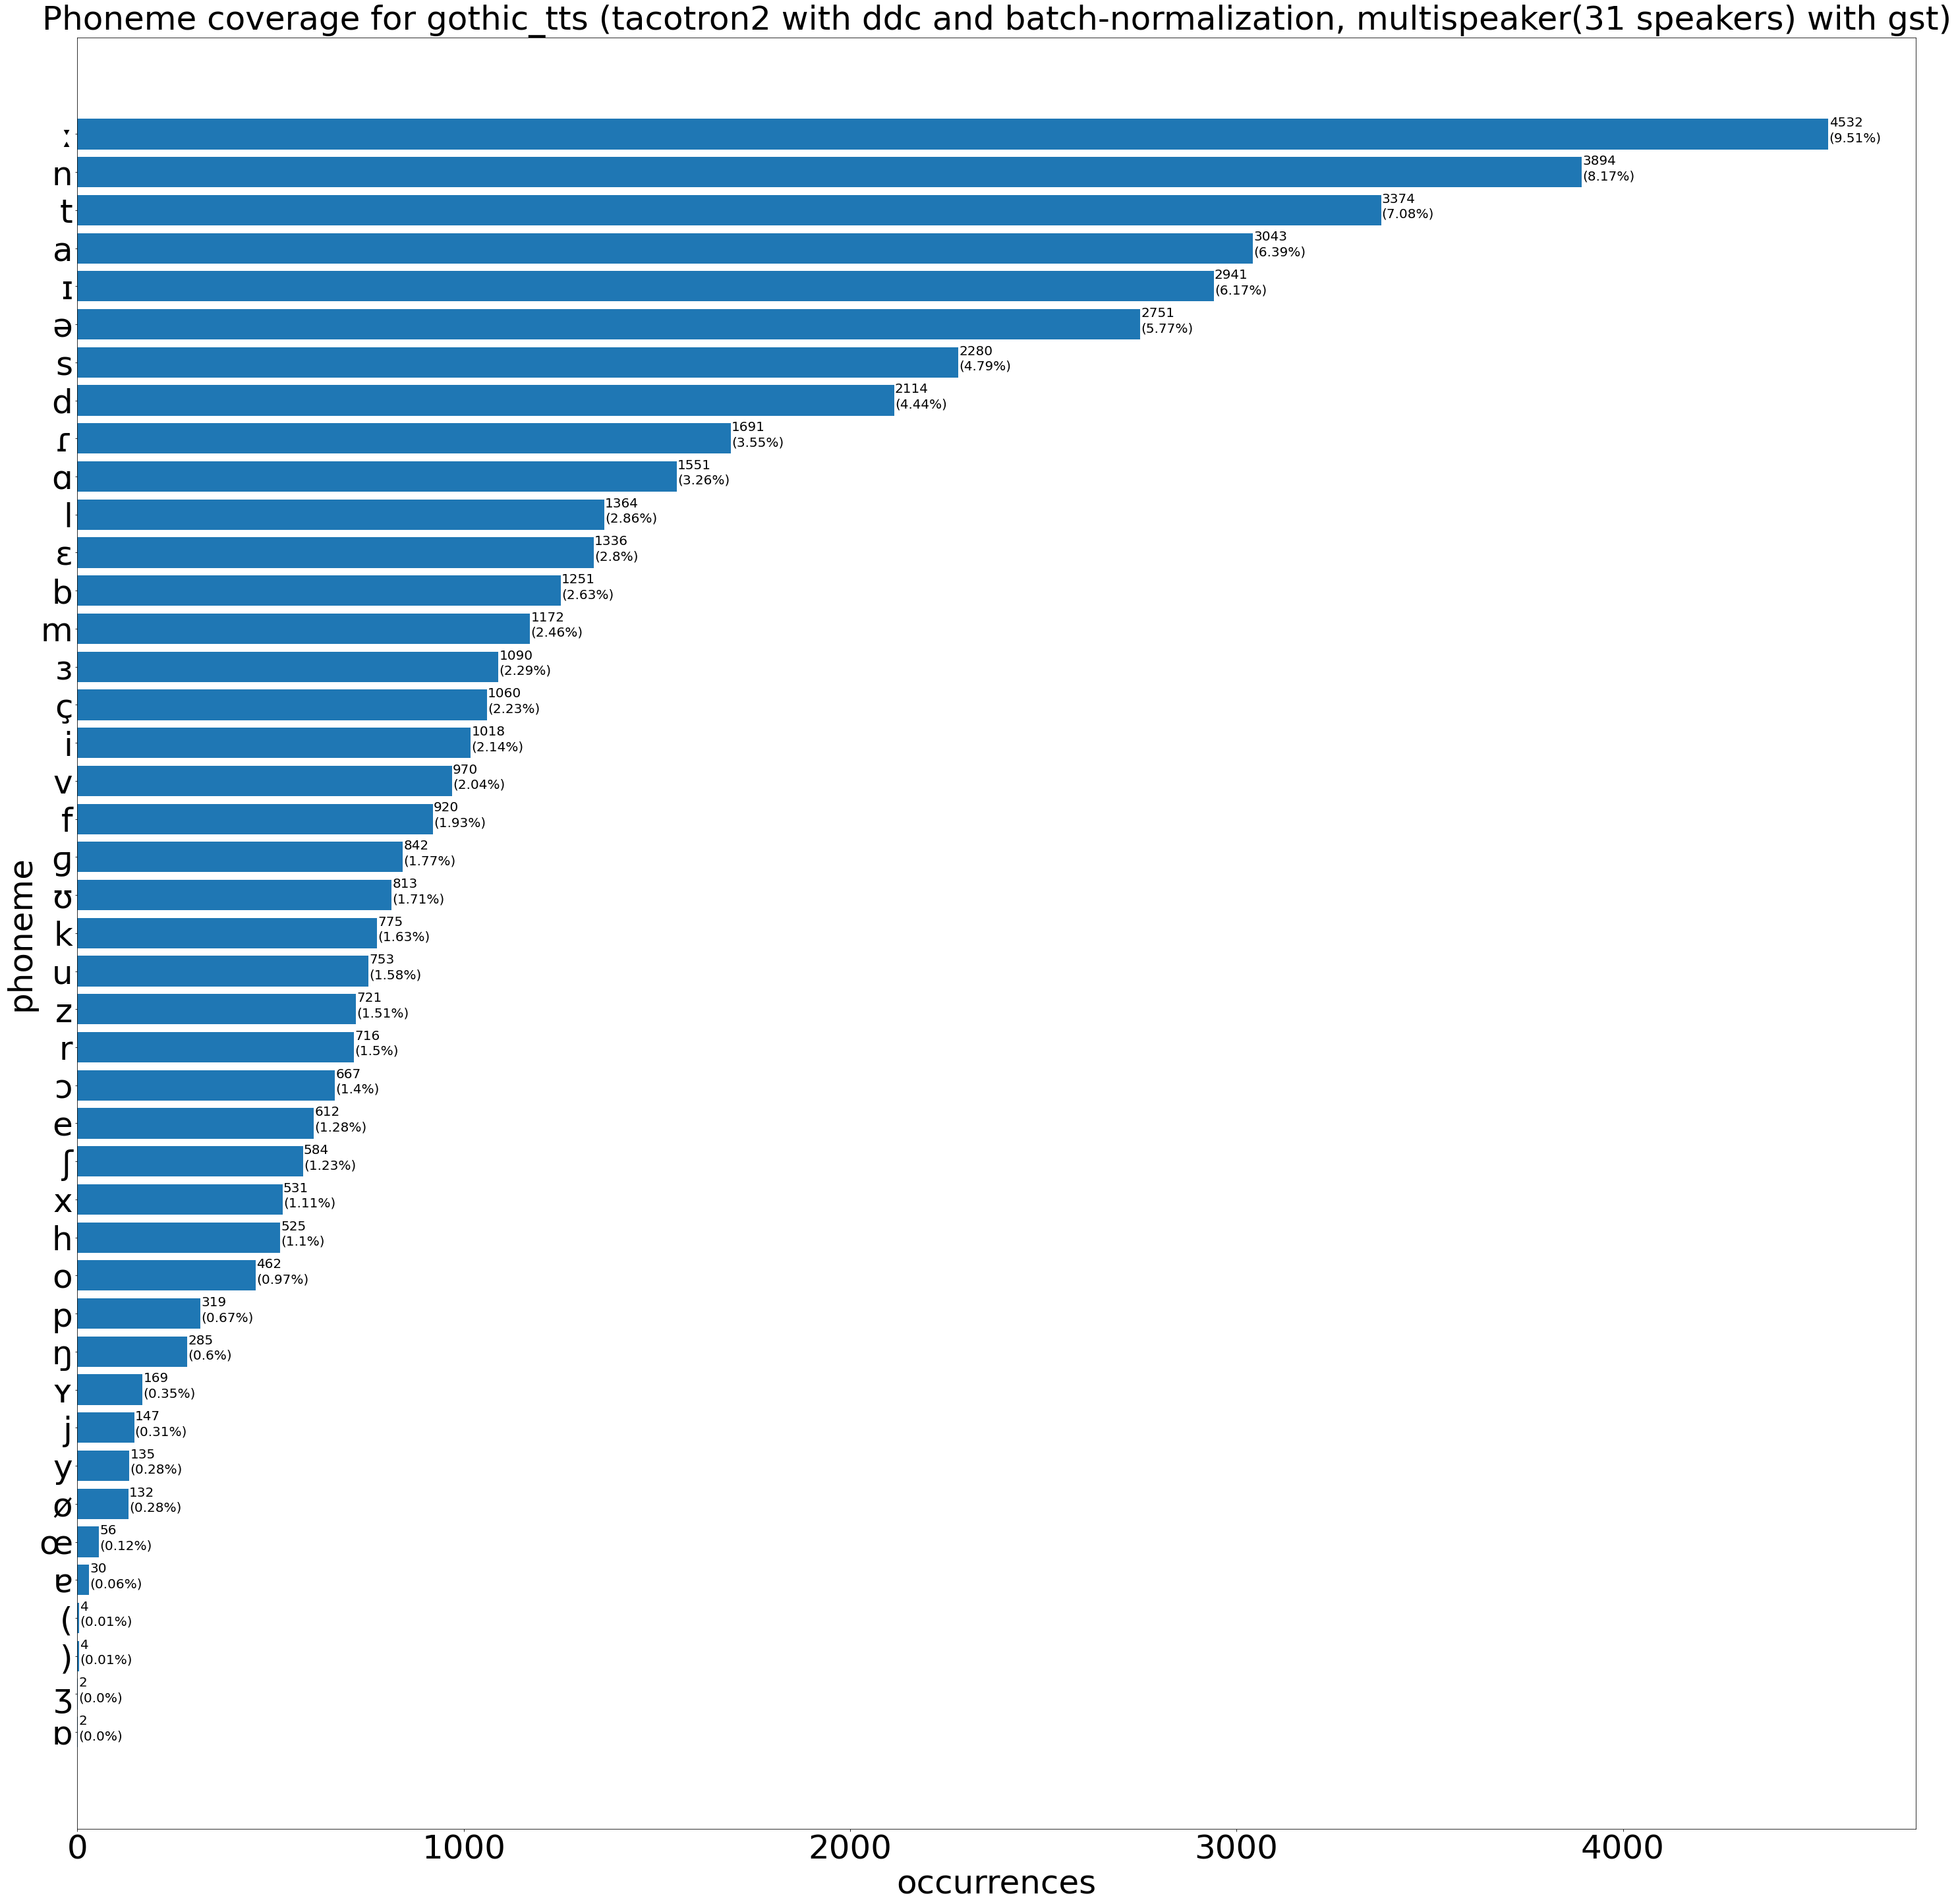

In [9]:
# create plot from analysis result

x = []
y = []

for key, value in sorted_d.items():
    x.append(key)
    y.append(value)

plt.figure(figsize=(50,50))
plt.title("Phoneme coverage for " + CONFIG_RUN_NAME + " (" + CONFIG_RUN_DESC + ")", fontsize=50)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.barh(x,y, align='center', alpha=1.0)
plt.gca().invert_yaxis()
plt.ylabel('phoneme', fontsize=50)
plt.xlabel('occurrences', fontsize=50)

for i, v in enumerate(y):
    plt.text(v + 2, i - .2, str(v), fontsize=20)
    plt.text(v + 2, i + .2, "(" + str(round(100/phonemesSum * v,2)) + "%)", fontsize=20)
    
    
plt.show()